# Udacity DRLND Collaboration and Competition

### Algorithm

The choice of algorithm to solve the Unity Tennis environment is [DDPG](https://arxiv.org/abs/1509.02971). Both players use different replay buffer.

### Hyperparameters

    BUFFER_SIZE = int(1e6)  # replay buffer size  
    BATCH_SIZE = 256        # minibatch size  
    GAMMA = 0.9             # discount factor  
    TAU = 1e-3              # for soft update of target parameters  
    LR_ACTOR = 1e-4         # learning rate of the actor  
    LR_CRITIC = 1e-4        # learning rate of the critic  
    WEIGHT_DECAY = 0.0001   # L2 weight decay

### Model architecture

For this project, I used a slightly simple neural network, so using GPU does not actually speed up much compared to training on CPU.

Actor-network

| <i></i>  |input units|output units|
|---|---|---|
|input layer|24|128|
|hidden layer|128|128|
|output layer|128|2|

Critic-network

| <i></i>  |input units|output units|
|---|---|---|
|input layer|24|128|
|hidden layer|128+2|128|
|output layer|128|1|

I also add batch normalization layer on most layers except before input and after output layer of Critic-network.

## 1. load the necessary package

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

%aimport ddpg_agents
from ddpg_agents import Agent
from model import Actor, Critic

In [3]:
file = "Tennis_Windows_x86_64/Tennis.exe"
env = UnityEnvironment(file_name=file)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
# examine the state space 
states = env_info.vector_observations
print('states shape: ', states.shape)
state_size = states.shape[1]
full_state_size = num_agents * state_size


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
states shape:  (2, 24)


## 2. training control

Due to the long training time, I come up with a simple idea to be able to stop and continue the training without losing any progress. I create a python dictionary called log to store some hyperparameters like total_episodes, etc. Then I use another python script called log_control to check and modify log. To be able to stop the training anytime I want, there is an item whose key called 'end_now', if I want to end the training, I simply call end_now() in log_control.py, then before the next episode, ddpg() will check if it's True, if yes, then ddpg() ends the training right away. 

In [30]:
import pickle
log = {
    'total_episodes': 3000,
    'current_episodes': 0,
    'scores': [],
    'save_every': 100,
    'print_every': 100,
    'end_now': False,
    'solved': False,
    'solved_score':0.5,
    'solve_in_episodes': None
}

import os.path
log_path = 'log.pkl'

def save_log(log_path, log):
    with open(log_path, 'wb') as f: 
        pickle.dump(log, f)
def load_log(log_path):
    with open(log_path, 'rb') as f: 
        log = pickle.load(f)
    return log

# uncomment the following line if you need to restart
# save_log(log_path, log)

if os.path.exists(log_path):
    log = load_log(log_path)
else:
    save_log(log_path, log)


## 3. Training

Episode 100	Average Score: 0.0040	Score: 0.0000
Episode 200	Average Score: 0.0070	Score: 0.0000
Episode 300	Average Score: 0.0130	Score: 0.0000
Episode 400	Average Score: 0.0050	Score: 0.0000
Episode 500	Average Score: 0.0160	Score: 0.0000
Episode 600	Average Score: 0.0110	Score: 0.0000
Episode 700	Average Score: 0.0110	Score: 0.0000
Episode 800	Average Score: 0.0380	Score: 0.1000
Episode 900	Average Score: 0.0620	Score: 0.1000
Episode 1000	Average Score: 0.0880	Score: 0.1000
Episode 1100	Average Score: 0.0770	Score: 0.0000
Episode 1200	Average Score: 0.0940	Score: 0.0000
Episode 1300	Average Score: 0.0760	Score: 0.1000
Episode 1400	Average Score: 0.1090	Score: 0.2000
Episode 1500	Average Score: 0.1210	Score: 0.1000
Episode 1600	Average Score: 0.1038	Score: 0.1000
Episode 1700	Average Score: 0.1090	Score: 0.1000
Episode 1800	Average Score: 0.1190	Score: 0.1000
Episode 1900	Average Score: 0.1490	Score: 0.1000
Episode 2000	Average Score: 0.2210	Score: 0.1000
Episode 2100	Average Score: 0

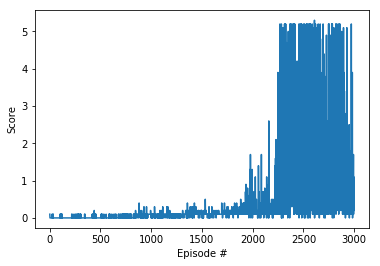

Wall time: 6h 9min 58s


In [31]:
%%time

# agent = Agent(state_size=state_size, full_state_size=full_state_size, action_size=action_size, 
#               num_agents=num_agents, num_process=2, random_seed=0)

agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, num_process=2, random_seed=0)

def ddpg(max_t=1000, log=log, log_path=log_path):
    # ----------load variables
    total_episodes = log['total_episodes']
    current_episodes = log['current_episodes']
    scores = log['scores']
    save_every = log['save_every']
    print_every = log['print_every']
    solved = log['solved']
    solved_score = log['solved_score']
    scores_deque = deque(maxlen=100)

    # ----------load weights if continue training
    if current_episodes != 0:
        agent.load_weights()

    for i_episode in range(current_episodes + 1, total_episodes + 1):

        # -----check if need to end the training-------
        log = load_log(log_path)
        if log['end_now']:
            log['end_now'] = False
            save_log(log_path, log)
            break

        # -----generating state--------
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment    
        states = env_info.vector_observations  # get the current state (for each agent)
        agent.reset()
        score = 0

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]  # send all actions to tne environment
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)

            states = next_states
            score += np.max(rewards)
            if np.any(dones):
                break
        scores_deque.append(score)
        scores.append(score)

        print('\rEpisode {}\tAverage Score: {:.4f}\tScore: {:.4f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > solved_score and solved == False:
            print('\nenvironment solved in {}th episodes'.format(i_episode))
            solved = True
            log['solved'] = True
            agent.save_weights()
            save_log(log_path, log)

        if i_episode % save_every == 0:
            log['current_episodes'] = i_episode
            log['scores'] = scores
            save_log(log_path, log)
            agent.save_weights()
    if np.mean(scores_deque) > solved_score:
        agent.save_weights()
    return scores


scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Replay

In [45]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, num_process=2, random_seed=0)
agent.load_weights()

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)

    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += np.max(env_info.rewards)                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.9000000134110451


## 5. Future improve

First, I tried to implement maddpg to solve the tennis environment, however, the agent learned nothing after 30k episodes(the rewards is 0 for most of the times). However, when I checked the loss, the algorithm did reduce the loss. That means one thing, the critic couldn't give good advice of all time. Consider the only change I did to the model architecture of critic is to change state and action dimension to full state and action dimension. And the way I get full state space is to simply concatenate two states space from both players, I think this is the reason the critic learned nothing. For one reason, both state space contains the position and velocity of the ball, but it seems they are additive inverse. However, without the detailed knowledge of state space, I couldn't get a full state space without redudent information.

Second, although ddpg successfully solved this environment, it seems that the performance of the agent stated to drop after 2900th episodes.

So, there are some future works for me to explore and improve my agent.

1. trying to get full state space without redudent information, in other words, make maddpg works. 

	The reason for maddpg is better than ddpg in this environment is if you check the replay. ddpg agent only knows its own environment, it wouldn't know if its opponent was unable to hit the ball(foul ball). But for maddpg agent, at least it has information of full state thus potentially knowing how to deliver the ball.  
    

2. keep digging the limitation of the performance of ddpg agent in this environment. Though ddpg has no info on its opponent, however, given enough episodes, I believe it should be able to learn how to deliver the ball.